<a href="https://colab.research.google.com/github/DanielWarfield1/MLWritingAndResearch/blob/main/GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Screw label propegation

stealing like an artist
https://stellargraph.readthedocs.io/en/latest/demos/node-classification/gcn-node-classification.html


In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.2 MB/s eta 0:00:00


In [2]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='./data', name='Cora')

data = dataset[0]
print(f"Num Nodes: {data.num_nodes}")
print(f"Num Features per Node: {data.num_node_features}")
print(f"Num Classes: {dataset.num_classes}")

Processing...


Num Nodes: 2708
Num Features per Node: 1433
Num Classes: 7


Done!


# Understanding the Dataset Fundamentals

In [3]:
print('feature data: ', data.x.shape)
print('labels: ', data.y.shape)
print('adjacency data: ', data.edge_index.shape)
print('example of a few edges:')
print(data.edge_index[:,0:10])

feature data:  torch.Size([2708, 1433])
labels:  torch.Size([2708])
adjacency data:  torch.Size([2, 10556])
example of a few edges:
tensor([[ 633, 1862, 2582,    2,  652,  654,    1,  332, 1454, 1666],
        [   0,    0,    0,    1,    1,    1,    2,    2,    2,    2]])


# Visualizing

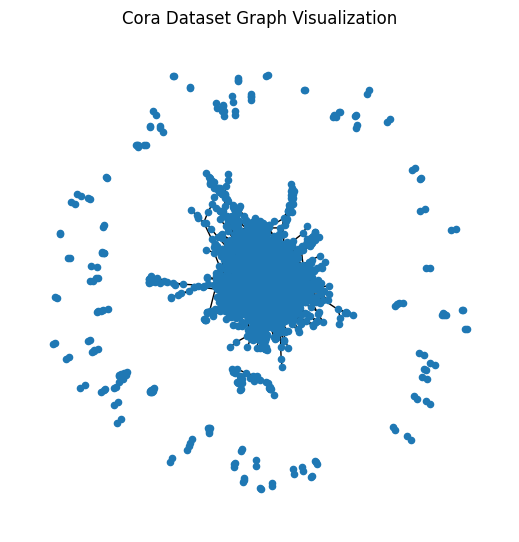

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

# Convert edge_index to NetworkX graph
edge_index = data.edge_index.numpy()
G = nx.Graph()
edges = edge_index.T.tolist()
G.add_edges_from(edges)

# Plot the graph
plt.figure(figsize=(5, 5))
nx.draw(G, node_size=20, with_labels=False)
plt.title("Cora Dataset Graph Visualization")
plt.axis('off')
plt.show()

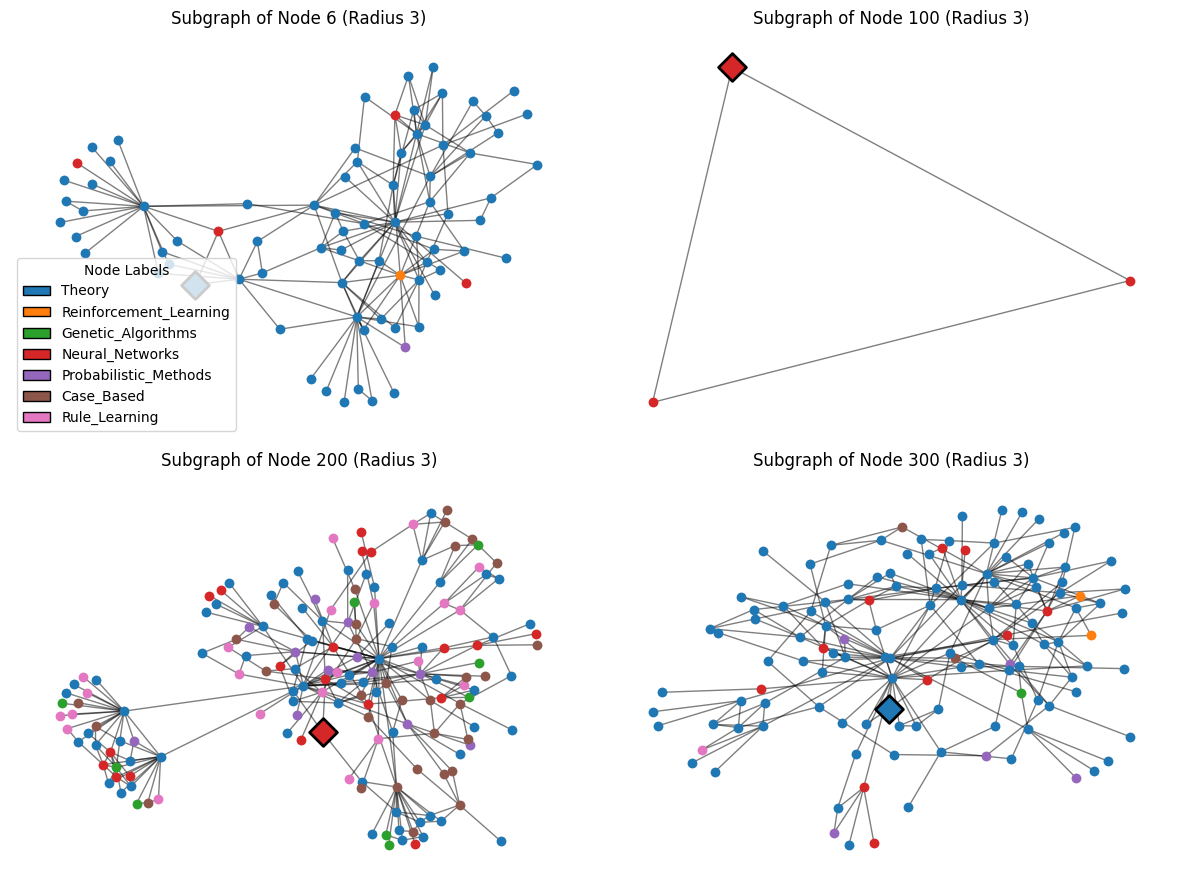

In [5]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import k_hop_subgraph
from matplotlib.patches import Patch

# Define label mapping
label_mapping = {
    0: "Theory",
    1: "Reinforcement_Learning",
    2: "Genetic_Algorithms",
    3: "Neural_Networks",
    4: "Probabilistic_Methods",
    5: "Case_Based",
    6: "Rule_Learning"
}

# Define a fixed color map to maintain consistency across subgraphs
fixed_colors = {
    label: plt.cm.tab10(i) for i, label in enumerate(label_mapping.keys())
}

# Visualize multiple subgraphs around specified nodes
def visualize_subgraphs(node_indices, radius=2):
    fig, axs = plt.subplots(2, 2, figsize=(12, 9))
    axs = axs.flatten()

    for ax, node_idx in zip(axs, node_indices):
        subset, edge_index, _, _ = k_hop_subgraph(node_idx, radius, data.edge_index, relabel_nodes=True)
        subG = nx.Graph()
        subG.add_edges_from(edge_index.t().tolist())

        # Get node labels
        node_labels = data.y[subset].tolist()
        node_colors = [fixed_colors[label] for label in node_labels]

        # Node sizes and shapes
        node_sizes = [200 if node == 0 else 50 for node in range(len(subset))]
        node_shapes = ['D' if node == 0 else 'o' for node in range(len(subset))]

        pos = nx.spring_layout(subG, seed=42)

        for i, node in enumerate(subG.nodes()):
            nx.draw_networkx_nodes(
                subG,
                pos,
                nodelist=[node],
                node_color=[node_colors[i]],
                node_size=node_sizes[i],
                node_shape=node_shapes[i],
                edgecolors='black' if node_shapes[i] == 'D' else None,
                linewidths=2 if node_shapes[i] == 'D' else 0,
                alpha=1.0
            )

        nx.draw_networkx_edges(subG, pos, alpha=0.5)

        # Use a single, consistent legend for all subgraphs
        if node_idx == node_indices[0]:  # Only create legend once
            legend_elements = [Patch(facecolor=fixed_colors[label], edgecolor='black', label=label_mapping[label])
                               for label in fixed_colors.keys()]
            ax.legend(handles=legend_elements, loc='best', title="Node Labels")

        ax.set_title(f"Subgraph of Node {node_idx} (Radius {radius})")
        plt.sca(ax)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example: Visualizing subgraphs around nodes 6, 100, 200, and 300
visualize_subgraphs(node_indices=[6, 100, 200, 300], radius=3)


# Understanding Vocab
Apparently it's kind of hard to find the vocabulary of the dataset. I did find an R library though, and we can use rpy2 to connect to that library and download the vocabulary.

In [6]:
!pip install rpy2

In [7]:
# Import necessary modules from rpy2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

# Activate automatic pandas conversion
pandas2ri.activate()

# Install and import lda package from R
utils = importr('utils')
utils.chooseCRANmirror(ind=1)  # select a CRAN mirror
utils.install_packages('lda')

# Import the 'lda' package
lda = importr('lda')

# Load 'cora.vocab' dataset
ro.r('data(cora.vocab)')

# Retrieve vocabulary as a Python list
cora_vocab = list(ro.r('cora.vocab'))

print('all words in cora vocabulary:')
print(cora_vocab)

(as ‘lib’ is unspecified)







	‘/tmp/RtmpuTR9ae/downloaded_packages’



all words in cora vocabulary:
[np.str_('computer'), np.str_('algorithms'), np.str_('discovering'), np.str_('patterns'), np.str_('groups'), np.str_('protein'), np.str_('sequences'), np.str_('based'), np.str_('fitting'), np.str_('parameters'), np.str_('statistical'), np.str_('model'), np.str_('group'), np.str_('related'), np.str_('include'), np.str_('hidden'), np.str_('markov'), np.str_('multiple'), np.str_('sequence'), np.str_('alignment'), np.str_('gibbs'), np.str_('sampler'), np.str_('producing'), np.str_('models'), np.str_('incorrect'), np.str_('produced'), np.str_('situation'), np.str_('convex'), np.str_('combination'), np.str_('weighted'), np.str_('average'), np.str_('paper'), np.str_('presents'), np.str_('solution'), np.str_('problem'), np.str_('combinations'), np.str_('form'), np.str_('heuristic'), np.str_('extremely'), np.str_('variance'), np.str_('dirichlet'), np.str_('mixture'), np.str_('priors'), np.str_('part'), np.str_('call'), np.str_('increases'), np.str_('strength'), np.

In [8]:
for elm in [str(elm) for elm in cora_vocab[:20]]:
    print(elm)

computer
algorithms
discovering
patterns
groups
protein
sequences
based
fitting
parameters
statistical
model
group
related
include
hidden
markov
multiple
sequence
alignment


# Understanding Masking

In [9]:
print(data.x.shape)
print(data.train_mask.shape)
print(data.train_mask)

torch.Size([2708, 1433])
torch.Size([2708])
tensor([ True,  True,  True,  ..., False, False, False])


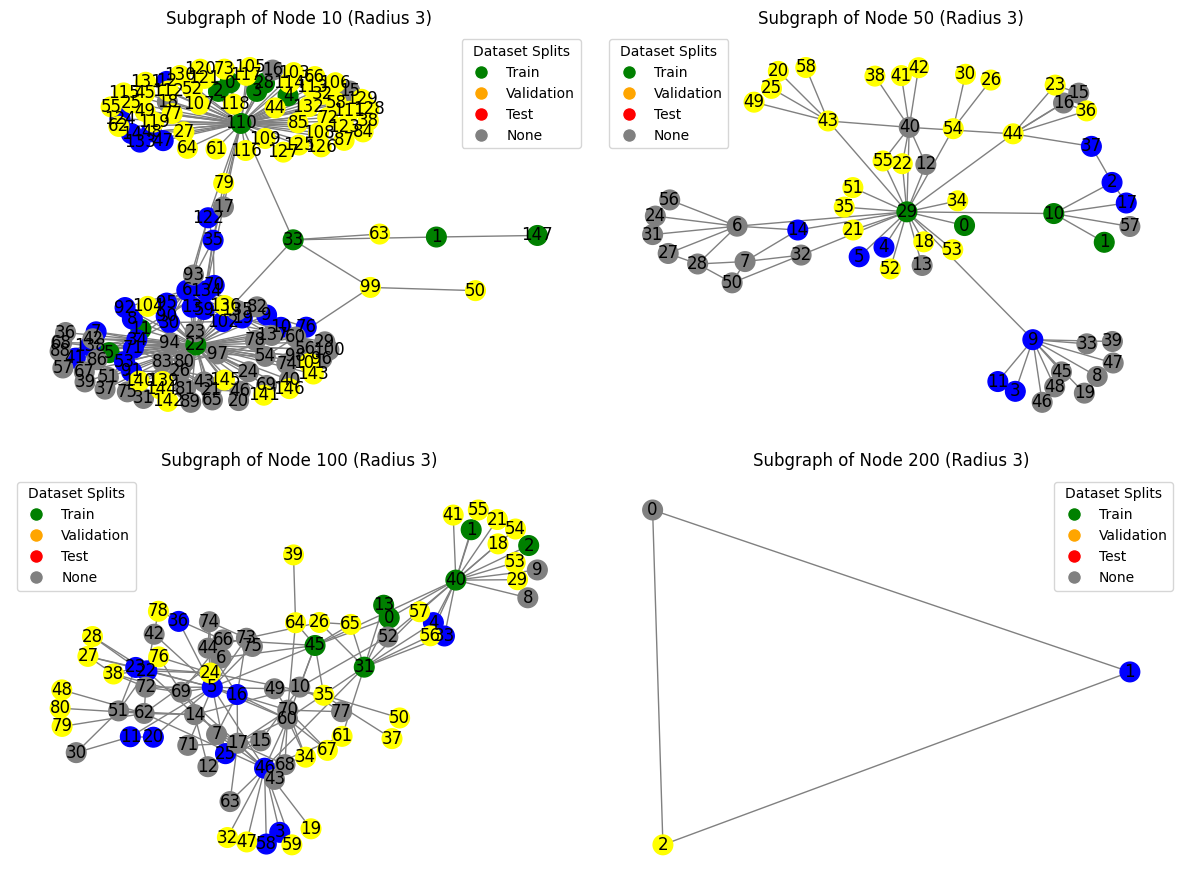

In [11]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import k_hop_subgraph

# Visualize subgraphs colored by dataset split
def visualize_subgraphs_by_split(node_indices, radius=2):
    fig, axs = plt.subplots(2, 2, figsize=(12, 9))
    axs = axs.flatten()

    for ax, node_idx in zip(axs, node_indices):
        subset, edge_index, _, _ = k_hop_subgraph(node_idx, radius, data.edge_index, relabel_nodes=True)

        # Determine node colors based on split
        node_colors = []
        for idx in subset.numpy():
            if data.train_mask[idx]:
                node_colors.append('green')
            elif data.val_mask[idx]:
                node_colors.append('blue')
            elif data.test_mask[idx]:
                node_colors.append('yellow')
            else:
                node_colors.append('gray')  # unknown or unspecified

        # Legend elements
        legend_elements = [
            plt.Line2D([0], [0], marker='o', color='w', label='Train', markerfacecolor='green', markersize=10),
            plt.Line2D([0], [0], marker='o', color='w', label='Validation', markerfacecolor='orange', markersize=10),
            plt.Line2D([0], [0], marker='o', color='w', label='Test', markerfacecolor='red', markersize=10),
            plt.Line2D([0], [0], marker='o', color='w', label='None', markerfacecolor='gray', markersize=10)
        ]

        subgraph = nx.Graph()
        subgraph.add_edges_from(edge_index.t().tolist())

        pos = nx.spring_layout(subgraph)
        nx.draw(
            subgraph,
            pos,
            ax=ax,
            node_color=node_colors,
            edge_color='gray',
            with_labels=True,
            node_size=200
        )

        ax.set_title(f"Subgraph of Node {node_idx} (Radius {radius})")
        ax.legend(handles=legend_elements, loc='best', title="Dataset Splits")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
visualize_subgraphs_by_split([10, 50, 100, 200], radius=3)

# Naiive majority voting
How performant is this system if we just adopt the most common connected label?

In [ ]:
from collections import Counter

correct = 0
total = 0

# Iterate through all test nodes
for node_idx in torch.where(data.test_mask)[0]:
    neighbors = list(G.neighbors(int(node_idx)))

    # Consider only labeled neighbors (training nodes)
    neighbor_labels = [int(data.y[neighbor]) for neighbor in neighbors if data.train_mask[neighbor]]

    if neighbor_labels:
        # Predict using majority voting
        predicted_label = Counter(neighbor_labels).most_common(1)[0][0]
    else:
        # Default prediction if no labeled neighbors: majority label in training set
        predicted_label = Counter(data.y[data.train_mask].tolist()).most_common(1)[0][0]

    true_label = int(data.y[node_idx])

    if predicted_label == true_label:
        correct += 1
    total += 1

accuracy = correct / total
print(f"Majority-vote accuracy on test nodes: {accuracy:.4f}")

Majority-vote accuracy on test nodes: 0.4520


# Simple MLP
What if we disregard the graph structure, and instead employ a neural network based on the bag of words?

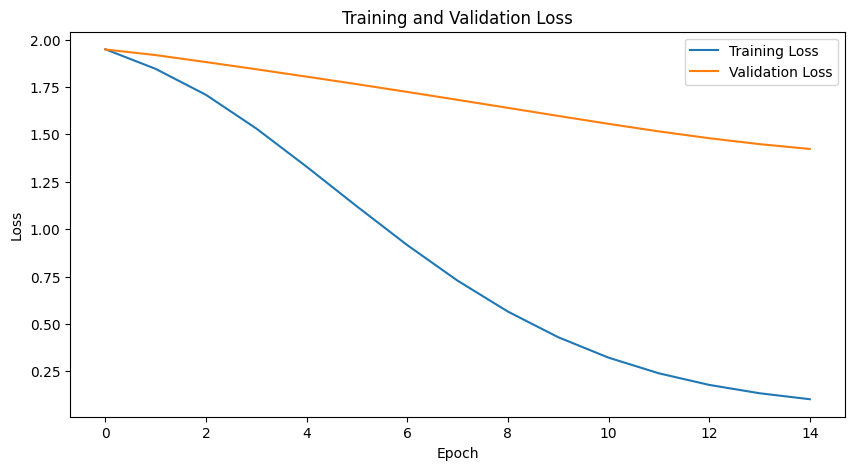

Test accuracy: 0.4950


In [ ]:
import torch.nn.functional as F

# Define a simple neural network (MLP)
class SimpleMLP(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# Initialize the model
model = SimpleMLP(dataset.num_features, 32, dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_losses = []
val_losses = []

# Training loop
for epoch in range(15):
    model.train()
    optimizer.zero_grad()
    out = model(data.x)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
        val_out = model(data.x)
        val_loss = F.cross_entropy(val_out[data.val_mask], data.y[data.val_mask])
        val_losses.append(val_loss.item())

# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Evaluate on test set
model.eval()
with torch.no_grad():
    logits = model(data.x)
    preds = logits[data.test_mask].argmax(dim=1)
    correct = (preds == data.y[data.test_mask]).sum().item()
    total = data.test_mask.sum().item()

test_accuracy = correct / total
print(f"Test accuracy: {test_accuracy:.4f}")

## Creating a GCN

In [12]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(num_features=dataset.num_node_features, hidden_channels=16, num_classes=dataset.num_classes)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


## Same thing, but from scratch
implemented with DeepSeek double checking GPT4's work.

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=False)

    def forward(self, x, edge_index):
        num_nodes = x.size(0)

        # Create adjacency matrix (including self-loops)
        edge_index = torch.cat([edge_index, torch.arange(num_nodes).repeat(2, 1)], dim=1)
        row, col = edge_index

        # Compute degree matrix
        deg = torch.bincount(row, minlength=num_nodes).float()
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg == 0] = 0  # Avoid division by zero

        # Construct D^(-1/2) * A * D^(-1/2)
        D_inv_sqrt = torch.diag(deg_inv_sqrt)
        A = torch.zeros((num_nodes, num_nodes), dtype=torch.float32)
        A[row, col] = 1  # Fill adjacency matrix
        A_norm = D_inv_sqrt @ A @ D_inv_sqrt  # Normalize A

        # Propagate features
        x = A_norm @ x  # Matrix multiplication with normalized adjacency
        x = self.linear(x)  # Apply learned transformation
        return x

class GCN(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNLayer(num_features, hidden_channels)
        self.conv2 = GCNLayer(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# Example usage:
model = GCN(num_features=dataset.num_node_features, hidden_channels=16, num_classes=dataset.num_classes)
print(model)


GCN(
  (conv1): GCNLayer(
    (linear): Linear(in_features=1433, out_features=16, bias=False)
  )
  (conv2): GCNLayer(
    (linear): Linear(in_features=16, out_features=7, bias=False)
  )
)


In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = pred[mask] == data.y[mask]
        accs.append(int(correct.sum()) / int(mask.sum()))
    return accs

for epoch in range(1, 201):
    loss = train()
    train_acc, val_acc, test_acc = test()
    if epoch % 20 == 0 or epoch == 1:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')



Epoch: 001, Loss: 1.9471, Train Acc: 0.8143, Val Acc: 0.5880, Test Acc: 0.5740
Epoch: 020, Loss: 0.4821, Train Acc: 0.9857, Val Acc: 0.7980, Test Acc: 0.8060
Epoch: 040, Loss: 0.1010, Train Acc: 1.0000, Val Acc: 0.7720, Test Acc: 0.8080
Epoch: 060, Loss: 0.0859, Train Acc: 1.0000, Val Acc: 0.7760, Test Acc: 0.8110
Epoch: 080, Loss: 0.0537, Train Acc: 1.0000, Val Acc: 0.7760, Test Acc: 0.8140
Epoch: 100, Loss: 0.0447, Train Acc: 1.0000, Val Acc: 0.7760, Test Acc: 0.8110
Epoch: 120, Loss: 0.0545, Train Acc: 1.0000, Val Acc: 0.7780, Test Acc: 0.8090
Epoch: 140, Loss: 0.0399, Train Acc: 1.0000, Val Acc: 0.7720, Test Acc: 0.8120
Epoch: 160, Loss: 0.0380, Train Acc: 1.0000, Val Acc: 0.7680, Test Acc: 0.8150
Epoch: 180, Loss: 0.0470, Train Acc: 1.0000, Val Acc: 0.7660, Test Acc: 0.8170
Epoch: 200, Loss: 0.0306, Train Acc: 1.0000, Val Acc: 0.7740, Test Acc: 0.8170


In [15]:
train_acc, val_acc, test_acc = test()
print(f"Final Test Accuracy: {test_acc:.4f}")


Final Test Accuracy: 0.8170


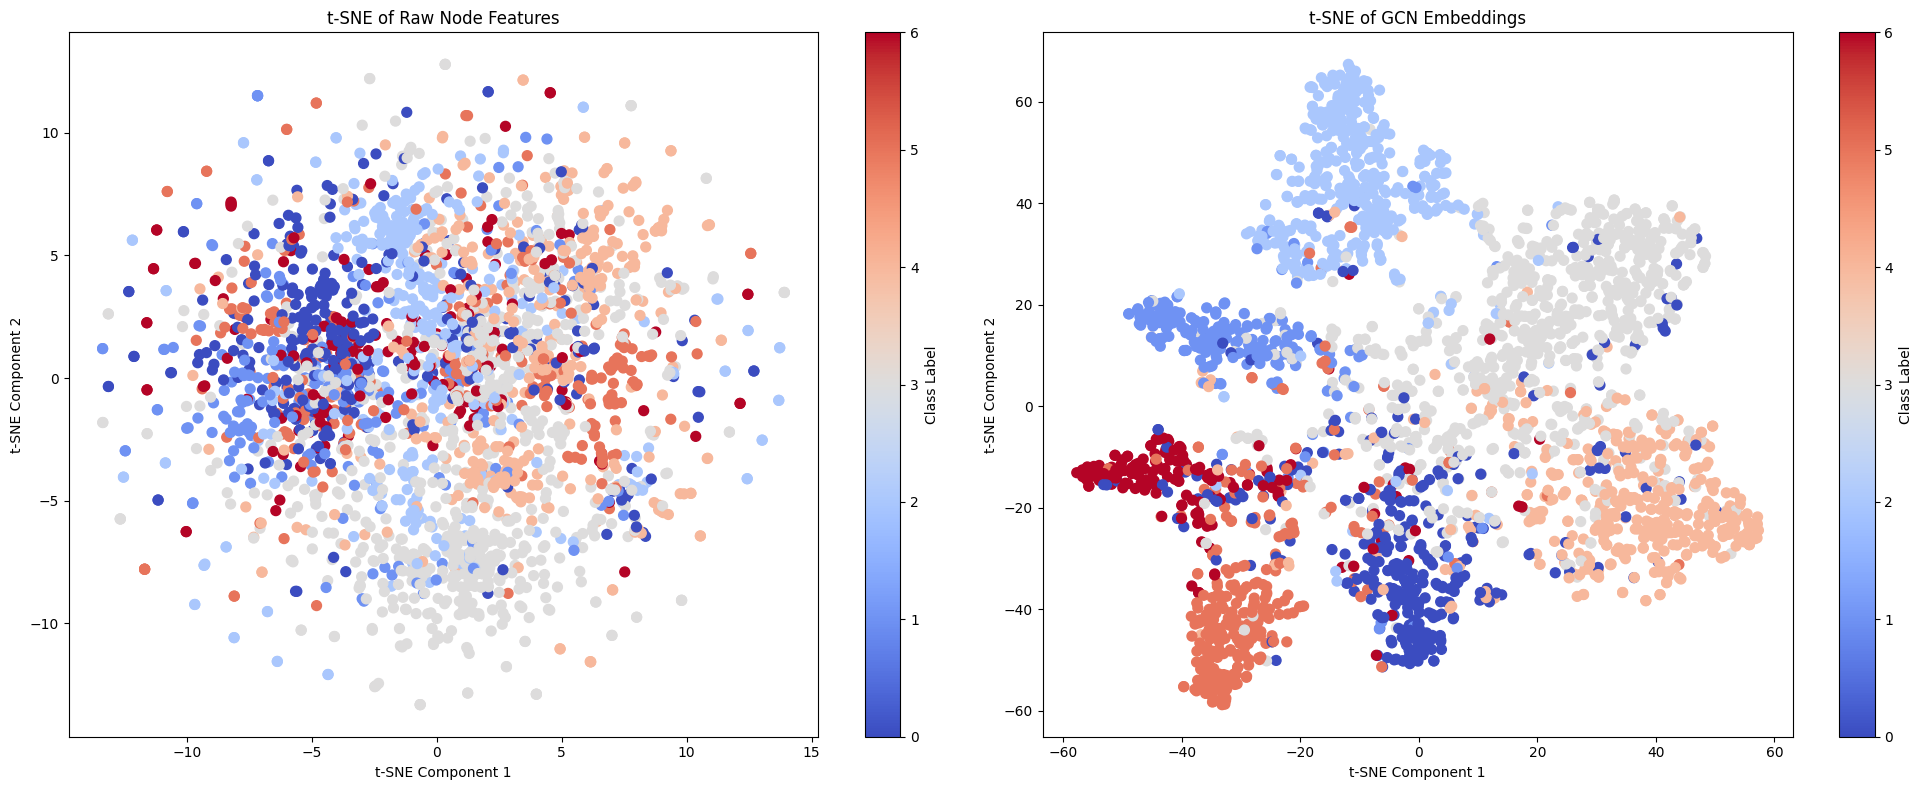

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Ensure model is in evaluation mode
model.eval()
with torch.no_grad():
    embeddings = model.conv1(data.x, data.edge_index)

# Apply t-SNE to raw features
tsne_raw = TSNE(n_components=2, random_state=42)
raw_features_2d = tsne_raw.fit_transform(data.x.cpu().numpy())

# Apply t-SNE to GCN embeddings
tsne_emb = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne_emb.fit_transform(embeddings.cpu().numpy())

# Plot both embeddings side-by-side
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot raw features
scatter_raw = axes[0].scatter(raw_features_2d[:, 0], raw_features_2d[:, 1],
                              c=data.y.cpu().numpy(), cmap='coolwarm', s=50)
axes[0].set_title('t-SNE of Raw Node Features')
axes[0].set_xlabel('t-SNE Component 1')
axes[0].set_ylabel('t-SNE Component 2')
fig.colorbar(scatter_raw, ax=axes[0], label='Class Label')

# Plot GCN embeddings
scatter_emb = axes[1].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                              c=data.y.cpu().numpy(), cmap='coolwarm', s=50)
axes[1].set_title('t-SNE of GCN Embeddings')
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')
fig.colorbar(scatter_emb, ax=axes[1], label='Class Label')

plt.tight_layout()
plt.show()